# Sequential Monte Carlo

:::{post} Oct 19, 2021
:tags: SMC 
:category: beginner
:::

In [1]:
import arviz as az
import numpy as np
import pymc as pm
import pytensor.tensor as pt

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.0.0b6


In [2]:
az.style.use("arviz-darkgrid")

Sampling from distributions with multiple peaks with standard MCMC methods can be difficult, if not impossible, as the Markov chain often gets stuck in either of the minima. A Sequential Monte Carlo sampler (SMC) is a way to ameliorate this problem.

As there are many SMC flavors, in this notebook we will focus on the version implemented in PyMC.

SMC combines several statistical ideas, including [importance sampling](https://en.wikipedia.org/wiki/Importance_sampling), tempering and MCMC. By tempering we mean the use of an auxiliary _temperature_ parameter to control the sampling process. To see how tempering can help let's write the posterior as:

$$p(\theta \mid y)_{\beta} \propto p(y \mid \theta)^{\beta} \; p(\theta)$$

When $\beta=0$ we have that $p(\theta \mid y)_{\beta=0}$ is the prior distribution and when $\beta=1$ we recover the _true_ posterior. We can think of $\beta$ as a knob we can use to gradually _fade up_ the likelihood. This can be useful as in general sampling from the prior is easier than sampling from the posterior distribution. Thus we can use $\beta$ to control the transition from an easy to sample distribution to a harder one.

A summary of the algorithm is:

1. Initialize $\beta$ at zero and stage at zero.
2. Generate N samples $S_{\beta}$ from the prior (because when $\beta = 0$ the tempered posterior is the prior).
3. Increase $\beta$ in order to make the effective sample size equals some predefined value (we use $Nt$, where $t$ is 0.5 by default).
4. Compute a set of N importance weights $W$. The weights are computed as the ratio of the likelihoods of a sample at stage $i+1$ and stage $i$.
5. Obtain $S_{w}$ by re-sampling according to $W$.
6. Use $W$ to compute the mean and covariance for the proposal distribution, a MVNormal.
7. For stages other than 0 use the acceptance rate from the previous stage to estimate `n_steps`.
8. Run N independent Metropolis-Hastings (IMH) chains (each one of length `n_steps`), starting each one from a different sample in $S_{w}$. Samples are IMH as the proposal mean is the of the previous posterior stage and not the current point in parameter space.
9. Repeat from step 3 until $\beta \ge 1$.
10. The final result is a collection of $N$ samples from the posterior

The algorithm is summarized in the next figure, the first subplot shows 5 samples (orange dots) at some particular stage. The second subplot shows how these samples are reweighted according to their posterior density (blue Gaussian curve). The third subplot shows the result of running a certain number of IMH steps, starting from the reweighted samples $S_{w}$ in the second subplot, notice how the two samples with the lower posterior density (smaller circles) are discarded and not used to seed new Markov chains.

![SMC stages](smc.png)


SMC samplers can also be interpreted in the light of genetic algorithms, which are biologically-inspired algorithms that can be summarized as follows:

1. Initialization: set a population of individuals
2. Mutation: individuals are somehow modified or perturbed
3. Selection: individuals with high _fitness_ have higher chance to generate _offspring_.
4. Iterate by using individuals from 3 to set the population in 1.

If each _individual_ is a particular solution to a problem, then a genetic algorithm will eventually produce good solutions to that problem. One key aspect is to generate enough diversity (mutation step) in order to explore the solution space and hence avoid getting trap in local minima. Then we perform a _selection_ step to _probabilistically_ keep reasonable solutions while also keeping some diversity. Being too greedy and short-sighted could be problematic, _bad_ solutions in a given moment could lead to _good_ solutions in the future.

For the SMC version implemented in PyMC we set the number of parallel Markov chains $N$ with the `draws` argument. At each stage SMC will use independent Markov chains to explore the _tempered posterior_ (the black arrow in the figure). The final samples, _i.e_ those stored in the `trace`, will be taken exclusively from the final stage ($\beta = 1$), i.e. the _true_ posterior ("true" in the mathematical sense).

The successive values of $\beta$ are determined automatically (step 3). The harder the distribution is to sample the closer two successive values of $\beta$ will be. And the larger the number of stages SMC will take. SMC computes the next $\beta$ value by keeping the effective sample size (ESS) between two stages at a constant predefined value of half the number of draws. This can be adjusted if necessary by the `threshold` parameter (in the interval [0, 1])-- the current default of 0.5 is generally considered as a good default. The larger this value, the higher the target ESS and the closer two successive values of $\beta$ will be. This ESS values are computed from the importance weights (step 4) and not from the autocorrelation like those from ArviZ (for example using `az.ess` or `az.summary`). 

Two more parameters that are automatically determined are:

* The number of steps each Markov chain takes to explore the _tempered posterior_ `n_steps`. This is determined from the acceptance rate from the previous stage.
* The covariance of the MVNormal proposal distribution is also adjusted adaptively based on the acceptance rate at each stage.

As with other sampling methods, running a sampler more than one time is useful to compute diagnostics, SMC is no exception. PyMC will try to run at least two **SMC _chains_** (do not confuse with the $N$ Markov chains inside each SMC chain).

Even when SMC uses the Metropolis-Hasting algorithm under the hood, it has several advantages over it:

* It can sample from distributions with multiple peaks.
* It does not have a burn-in period, it starts by sampling directly from the prior and then at each stage the starting points are already _approximately_ distributed according to the tempered posterior (due to the re-weighting step).
* It is inherently parallel.

## Solving a PyMC model with SMC

To see an example of how to use SMC inside PyMC let's define a multivariate Gaussian of dimension $n$ with two modes, the weights of each mode and the covariance matrix.

In [3]:
n = 4

mu1 = np.ones(n) * (1.0 / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

w1 = 0.1  # one mode with 0.1 of the mass
w2 = 1 - w1  # the other mode with 0.9 of the mass


def two_gaussians(x):
    log_like1 = (
        -0.5 * n * pt.log(2 * np.pi)
        - 0.5 * pt.log(dsigma)
        - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    )
    log_like2 = (
        -0.5 * n * pt.log(2 * np.pi)
        - 0.5 * pt.log(dsigma)
        - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    )
    return pm.math.logsumexp([pt.log(w1) + log_like1, pt.log(w2) + log_like2])

In [4]:
with pm.Model() as model:
    X = pm.Uniform(
        "X",
        shape=n,
        lower=-2.0 * np.ones_like(mu1),
        upper=2.0 * np.ones_like(mu1),
        initval=-1.0 * np.ones_like(mu1),
    )
    llk = pm.Potential("llk", two_gaussians(X))
    idata_04 = pm.sample_smc(2000)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


We can see from the message that PyMC is running four **SMC chains** in parallel. As explained before this is useful for diagnostics. As with other samplers one useful diagnostics is the `plot_trace`, here we use `kind="rank_vlines"` as rank plots as generally more useful than the classical "trace"

'Estimated w1 = 0.907'

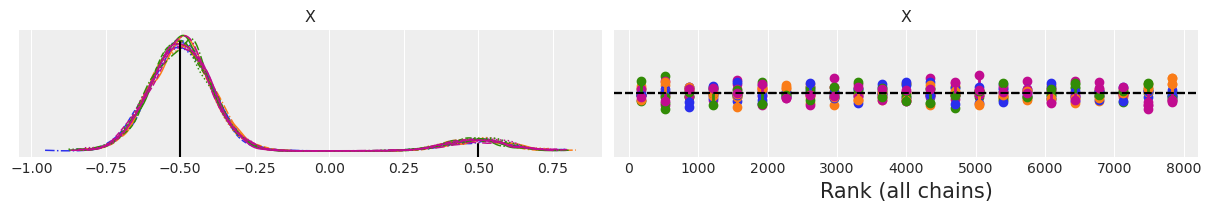

In [5]:
ax = az.plot_trace(idata_04, compact=True, kind="rank_vlines")
ax[0, 0].axvline(-0.5, 0, 0.9, color="k")
ax[0, 0].axvline(0.5, 0, 0.1, color="k")
f'Estimated w1 = {np.mean(idata_04.posterior["X"] < 0).item():.3f}'

From the KDE we can see that we recover the modes and even the relative weights seems pretty good. The rank plot on the right looks good too. One SMC chain is represented in blue and the other in orange. The vertical lines indicate deviation from the ideal expected value, which is represented with a black dashed line. If a vertical line is above the reference black dashed line we have more samples than expected, if the vertical line is below the sampler is getting less samples than expected. Deviations like the ones in the figure above are fine and not a reason for concern.

As previously said SMC internally computes an estimation of the ESS (from importance weights). Those ESS values are not useful for diagnostics as they are a fixed target value. We can compute the ESS values from the trace returned by `sample_smc`, but this is also not a very useful diagnostics, as the computation of this ESS value takes autocorrelation into account and each SMC run/chain has low autocorrelation by construction, for most problems the values of ESS will be either very close to the number of total samples (i.e. draws x chains). In general it will only be a low number if each SMC chain explores a different mode, in that case the value of ESS will be close to the number of modes.

## Kill your darlings

SMC is not free of problems, sampling can deteriorate as the dimensionality of the problem increases, in particular for multimodal posterior or _weird_ geometries as in hierarchical models. To some extent increasing the number of draws could help. Increasing the value of the argument `p_acc_rate` is also a good idea. This parameter controls how the number of steps is computed at each stage. To access the number of steps per stage you can check `trace.report.nsteps`. Ideally SMC will take a number of steps lower than `n_steps`. But if the actual number of steps per stage is `n_steps`, for a few stages, this may be signaling that we should also increase `n_steps`. 

Let's see the performance of SMC when we run the same model as before, but increasing the dimensionality from 4 to 80.

In [6]:
n = 80

mu1 = np.ones(n) * (1.0 / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

w1 = 0.1  # one mode with 0.1 of the mass
w2 = 1 - w1  # the other mode with 0.9 of the mass


def two_gaussians(x):
    log_like1 = (
        -0.5 * n * pt.log(2 * np.pi)
        - 0.5 * pt.log(dsigma)
        - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    )
    log_like2 = (
        -0.5 * n * pt.log(2 * np.pi)
        - 0.5 * pt.log(dsigma)
        - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    )
    return pm.math.logsumexp([pt.log(w1) + log_like1, pt.log(w2) + log_like2])

In [7]:
with pm.Model() as model:
    X = pm.Uniform(
        "X",
        shape=n,
        lower=-2.0 * np.ones_like(mu1),
        upper=2.0 * np.ones_like(mu1),
        initval=-1.0 * np.ones_like(mu1),
    )
    llk = pm.Potential("llk", two_gaussians(X))
    idata_80 = pm.sample_smc(2000)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


We see that SMC recognizes this is a harder problem and increases the number of stages. We can see that SMC still sample from both modes but now the model with higher weight is being oversampled (we get a relative weight of 0.99 instead of 0.9). Notice how the rank plot looks worse than when n=4.

'Estimated w1 = 0.991'

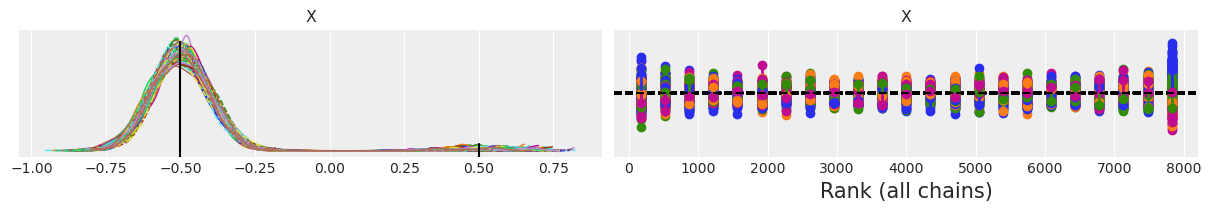

In [8]:
ax = az.plot_trace(idata_80, compact=True, kind="rank_vlines")
ax[0, 0].axvline(-0.5, 0, 0.9, color="k")
ax[0, 0].axvline(0.5, 0, 0.1, color="k")
f'Estimated w1 = {np.mean(idata_80.posterior["X"] < 0).item():.3f}'

You may want to repeat the SMC sampling for n=80, and change one or more of the default parameters too see if you can improve the sampling and how much time the sampler takes to compute the posterior.

In [9]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Tue May 31 2022

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.3.0

xarray: 2022.3.0

sys   : 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
arviz : 0.12.0
numpy : 1.21.5
pytensor: 2.6.2
pymc  : 4.0.0b6

Watermark: 2.3.0

